# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

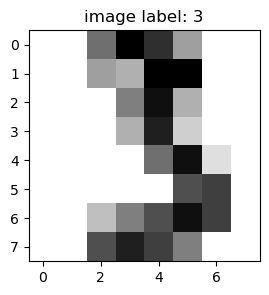

In [21]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [22]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [23]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [24]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [25]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [26]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)

Let's make sure that this works one vector at a time (and check that the components sum to one):

In [27]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [28]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [29]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [11]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [30]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [31]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [32]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [33]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

In [34]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = np.dot(X, self.W) + self.b
        
        # Return the softmax of the linear combination
        return softmax(Z)
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b

In [35]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

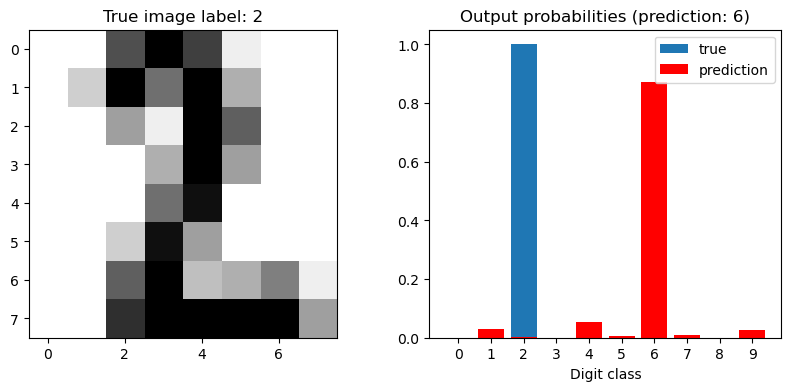

In [36]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [37]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: -0
Average NLL over the last 100 samples at step 100: 318
Average NLL over the last 100 samples at step 200: 147
Average NLL over the last 100 samples at step 300: 230
Average NLL over the last 100 samples at step 400: 108
Average NLL over the last 100 samples at step 500: 144
Average NLL over the last 100 samples at step 600: 215
Average NLL over the last 100 samples at step 700: 165
Average NLL over the last 100 samples at step 800: 31
Average NLL over the last 100 samples at step 900: 121
Average NLL over the last 100 samples at step 1000: 201
Average NLL over the last 100 samples at step 1100: 445
Average NLL over the last 100 samples at step 1200: 137
Average NLL over the last 100 samples at step 1300: 254
Average NLL over the last 100 samples at step 1400: 80
Average NLL over the last 100 samples at step 1500: 65


Evaluate the trained model on the first example:

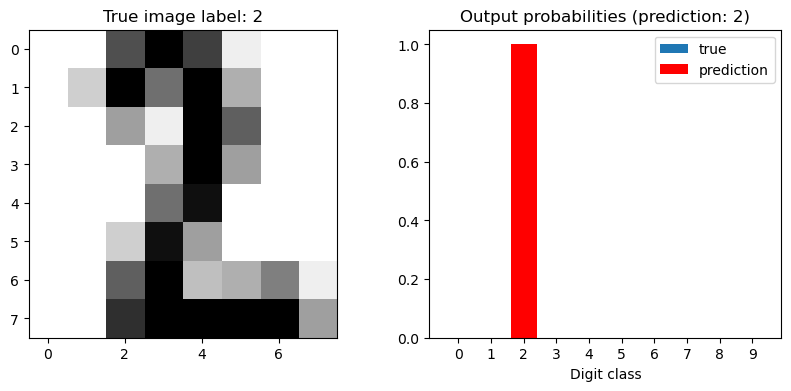

In [38]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

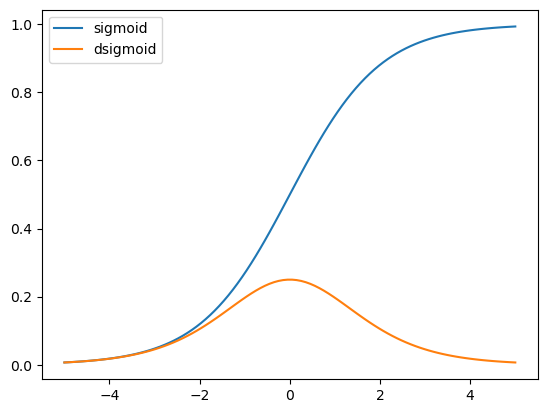

In [40]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    return 1 / (1 + np.exp(-X))


def dsigmoid(X):
    # Using the fact that sigmoid'(x) = sigmoid(x)(1 - sigmoid(x))
    s = sigmoid(X)
    return s * (1 - s)


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [41]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h

        # Apply the sigmoid activation function
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the sigmoid activation function
        return softmax(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)

        return Y

    def loss(self, X, y):
        # Convert true labels to one-hot
        y_onehot = one_hot(self.output_size, y)
    
        # Get predictions from forward pass
        y_pred = self.forward(X)
        
        # Compute negative log likelihood loss
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the code is written, we can test our model on a single sample:

In [42]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [43]:
model.loss(X_train, y_train)

3532.842373419112

In [44]:
model.accuracy(X_train, y_train)

0.10216110019646366

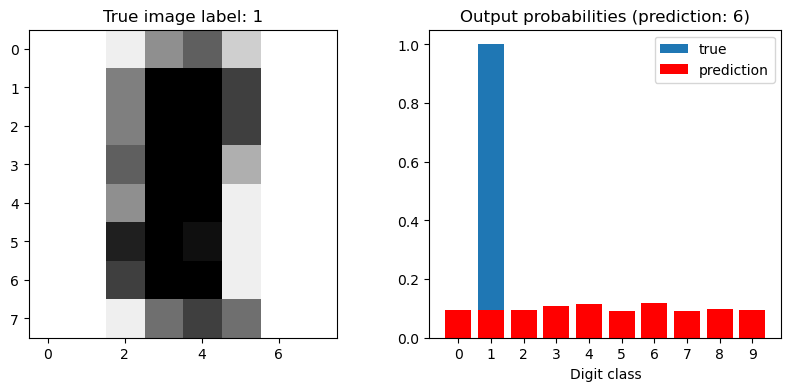

In [45]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [46]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 3532.84237, train acc: 0.102, test acc: 0.096
Epoch #1, train loss: 2770.27246, train acc: 0.517, test acc: 0.481
Epoch #2, train loss: 2061.55029, train acc: 0.608, test acc: 0.544
Epoch #3, train loss: 1793.90996, train acc: 0.580, test acc: 0.552
Epoch #4, train loss: 1990.39813, train acc: 0.400, test acc: 0.389
Epoch #5, train loss: 2165.76553, train acc: 0.460, test acc: 0.478
Epoch #6, train loss: 2202.75540, train acc: 0.454, test acc: 0.452
Epoch #7, train loss: 2177.49605, train acc: 0.506, test acc: 0.496
Epoch #8, train loss: 2250.53337, train acc: 0.584, test acc: 0.530
Epoch #9, train loss: 2086.45854, train acc: 0.646, test acc: 0.589
Epoch #10, train loss: 2027.61108, train acc: 0.640, test acc: 0.593
Epoch #11, train loss: 1991.62338, train acc: 0.650, test acc: 0.604
Epoch #12, train loss: 1936.85300, train acc: 0.648, test acc: 0.596
Epoch #13, train loss: 2032.39585, train acc: 0.620, test acc: 0.548
Epoch #14, train loss: 1944.29912, train 

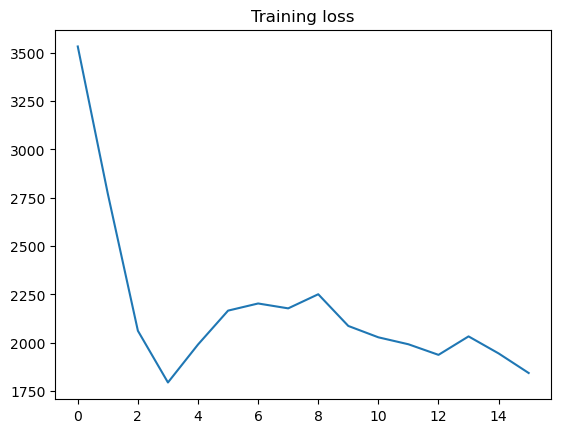

In [47]:
plt.plot(losses)
plt.title("Training loss");

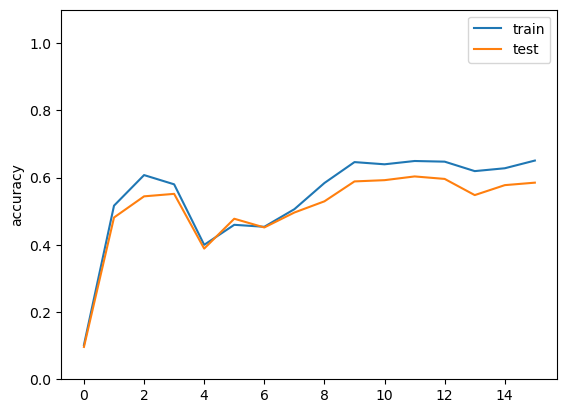

In [48]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

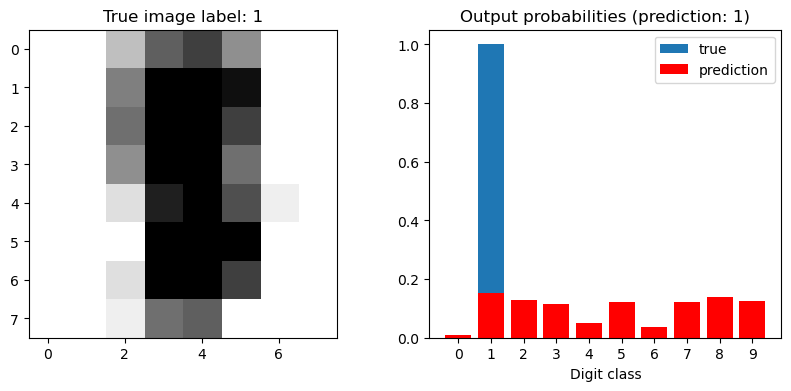

In [49]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?


True label: 4
Predicted probabilities: [4.77421365e-02 4.36343633e-01 2.11313675e-02 2.98860106e-04
 2.06694492e-02 8.97960424e-05 2.44247593e-01 2.02000626e-05
 2.28818007e-01 6.38957702e-04]
Confidence score for true class: 0.021


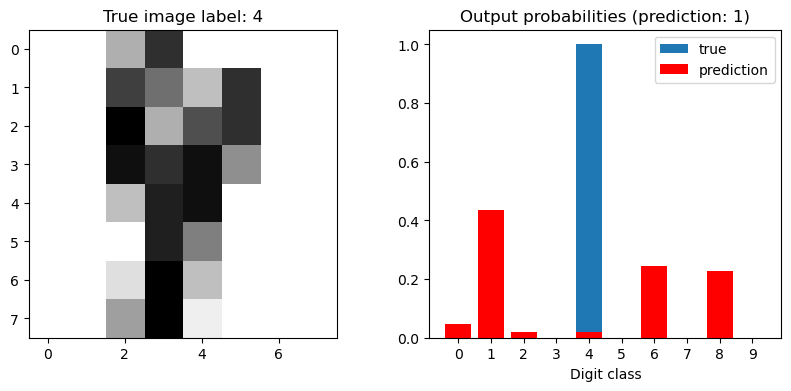


True label: 4
Predicted probabilities: [0.00529376 0.10866451 0.112621   0.13315564 0.04313223 0.15501221
 0.02471072 0.17601405 0.10042247 0.14097342]
Confidence score for true class: 0.043


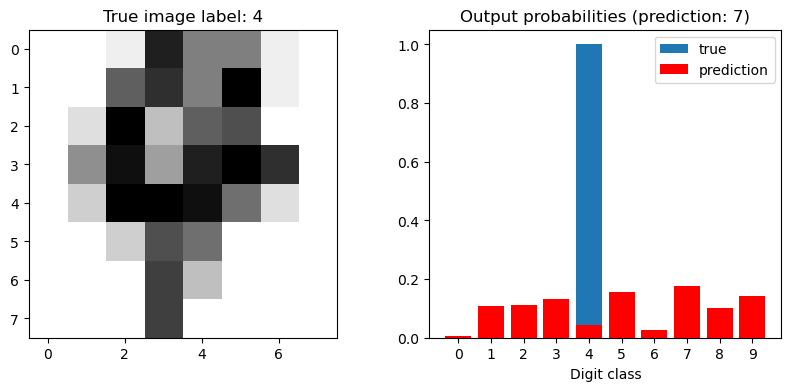


True label: 4
Predicted probabilities: [0.01249571 0.21348144 0.14057784 0.08645866 0.07980192 0.08597504
 0.05671101 0.09352883 0.13262826 0.09834128]
Confidence score for true class: 0.080


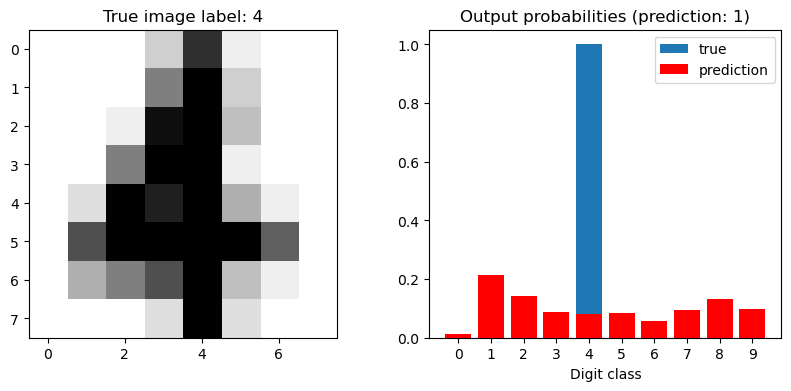


True label: 8
Predicted probabilities: [0.00507088 0.10555696 0.11254507 0.13586352 0.04151005 0.15760446
 0.02378707 0.17607042 0.09959037 0.1424012 ]
Confidence score for true class: 0.100


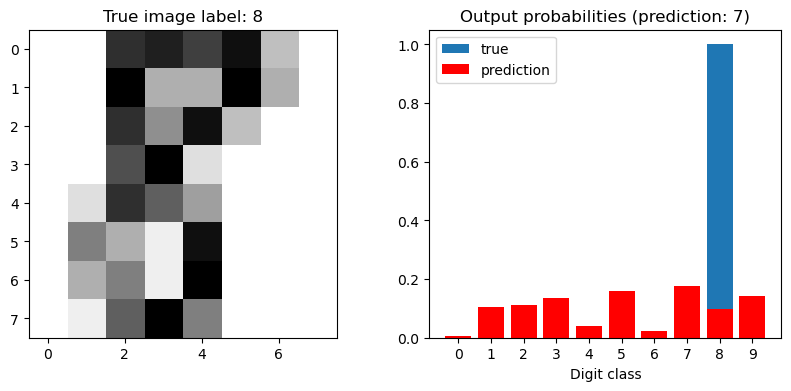


True label: 8
Predicted probabilities: [0.00505796 0.10592757 0.11265438 0.13560323 0.04151791 0.15752182
 0.02376951 0.17590811 0.09979871 0.1422408 ]
Confidence score for true class: 0.100


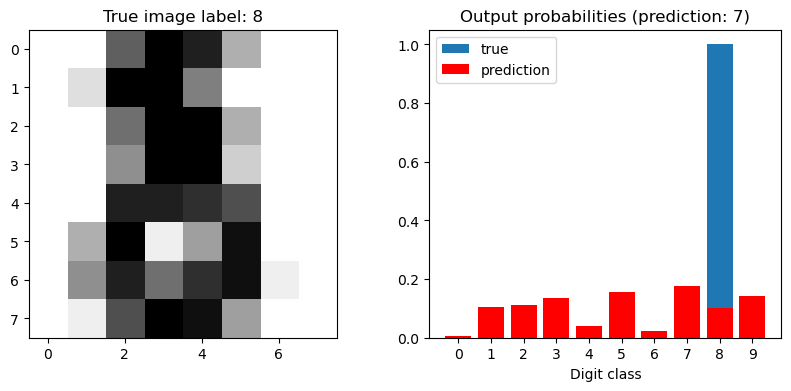

In [50]:
# Your code here

# Get predictions and their probabilities for all test samples
predictions = model.forward(X_test)  # Get predicted probabilities
true_classes = np.array([one_hot(10, y) for y in y_test])  # Convert true labels to one-hot

# Calculate confidence scores for the correct class
confidence_scores = np.sum(predictions * true_classes, axis=1)  # Element-wise multiply and sum

# Find indices of worst predictions (lowest confidence for correct class)
worst_indices = np.argsort(confidence_scores)[:5]  # Get indices of 5 worst predictions

# Plot each of the worst predictions
for idx in worst_indices:
    print(f"\nTrue label: {y_test[idx]}")
    print(f"Predicted probabilities:", predictions[idx])
    print(f"Confidence score for true class: {confidence_scores[idx]:.3f}")
    plot_prediction(model, sample_idx=idx)
    plt.show()

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [51]:

# Your code here

# Single Hidden Layer
def train_and_evaluate(model, epochs=10, verbose=True):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(len(X_train))
        
        # Train on each sample
        for idx in indices:
            model.train(X_train[idx], y_train[idx], learning_rate)
            
        # Record metrics
        train_loss = model.loss(X_train, y_train)
        test_acc = model.accuracy(X_test, y_test)
        train_losses.append(train_loss)
        test_accuracies.append(test_acc)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Test Accuracy: {test_acc:.4f}")
    
    return train_losses, test_accuracies

# Experiment with single hidden layer
hidden_sizes = [32, 64, 128, 256]
learning_rates = [0.1, 0.01, 0.001]

results = {}
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        print(f"\nTraining with hidden_size={hidden_size}, learning_rate={lr}")
        
        # Initialize model
        model = NeuralNet(input_size=X_train.shape[1], 
                         hidden_size=hidden_size,
                         output_size=10)
        
        # Train and evaluate
        learning_rate = lr  # Set global learning rate used in model.train()
        losses, accuracies = train_and_evaluate(model)
        
        # Store results
        key = f"hidden_{hidden_size}_lr_{lr}"
        results[key] = {
            "final_accuracy": accuracies[-1],
            "train_losses": losses,
            "test_accuracies": accuracies
        }

# Find best performing configuration
best_config = max(results.items(), key=lambda x: x[1]["final_accuracy"])
print("\nSingle Hidden Layer Results:")
print(f"Best configuration: {best_config[0]}")
print(f"Best test accuracy: {best_config[1]['final_accuracy']:.4f}")


Training with hidden_size=32, learning_rate=0.1
Epoch 5/10:
  Train Loss: 47456.2788
  Test Accuracy: 0.1037
Epoch 10/10:
  Train Loss: 47525.3563
  Test Accuracy: 0.1000

Training with hidden_size=32, learning_rate=0.01
Epoch 5/10:
  Train Loss: 19697.6393
  Test Accuracy: 0.2074
Epoch 10/10:
  Train Loss: 17235.9802
  Test Accuracy: 0.0963

Training with hidden_size=32, learning_rate=0.001
Epoch 5/10:
  Train Loss: 333.1913
  Test Accuracy: 0.9556
Epoch 10/10:
  Train Loss: 170.6313
  Test Accuracy: 0.9704

Training with hidden_size=64, learning_rate=0.1
Epoch 5/10:
  Train Loss: 47387.2012
  Test Accuracy: 0.0963
Epoch 10/10:
  Train Loss: 47352.6624
  Test Accuracy: 0.0889

Training with hidden_size=64, learning_rate=0.01
Epoch 5/10:
  Train Loss: 3196.7258
  Test Accuracy: 0.6444
Epoch 10/10:
  Train Loss: 44658.1601
  Test Accuracy: 0.1593

Training with hidden_size=64, learning_rate=0.001
Epoch 5/10:
  Train Loss: 256.2050
  Test Accuracy: 0.9630
Epoch 10/10:
  Train Loss: 141.

In [52]:
# Two Hidden Layers
class NeuralNetTwoLayers(NeuralNet):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        # First hidden layer weights and biases
        self.W_h1 = np.random.uniform(size=(input_size, hidden1_size),
                                     high=0.1, low=-0.1)
        self.b_h1 = np.random.uniform(size=hidden1_size,
                                     high=0.1, low=-0.1)
        
        # Second hidden layer weights and biases
        self.W_h2 = np.random.uniform(size=(hidden1_size, hidden2_size),
                                     high=0.1, low=-0.1)
        self.b_h2 = np.random.uniform(size=hidden2_size,
                                     high=0.1, low=-0.1)
        
        # Output layer weights and biases
        self.W_o = np.random.uniform(size=(hidden2_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)
        
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size
        
    def forward(self, X):
        # First hidden layer
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        self.H1 = sigmoid(self.Z_h1)
        
        # Second hidden layer
        self.Z_h2 = np.dot(self.H1, self.W_h2) + self.b_h2
        self.H2 = sigmoid(self.Z_h2)
        
        # Output layer
        self.Z_o = np.dot(self.H2, self.W_o) + self.b_o
        Y = softmax(self.Z_o)
        
        return Y
        
    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)
        
        # Output layer error
        error_o = y_pred - y_true
        grad_W_o = np.dot(self.H2.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)
        
        # Second hidden layer error
        error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h2)
        grad_W_h2 = np.dot(self.H1.T, error_h2)
        grad_b_h2 = np.sum(error_h2, axis=0)
        
        # First hidden layer error
        error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.Z_h1)
        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)
        
        return {
            "W_h1": grad_W_h1, "b_h1": grad_b_h1,
            "W_h2": grad_W_h2, "b_h2": grad_b_h2,
            "W_o": grad_W_o, "b_o": grad_b_o
        }
    
    def train(self, x, y, learning_rate):
        x = x[np.newaxis, :] if len(x.shape) == 1 else x
        grads = self.grad_loss(x, y)
        
        # Update all weights and biases
        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]
        self.W_h2 -= learning_rate * grads["W_h2"]
        self.b_h2 -= learning_rate * grads["b_h2"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

# Experiment with two hidden layers
hidden1_sizes = [64, 128, 256]
hidden2_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001]

results_two_layers = {}
for h1 in hidden1_sizes:
    for h2 in hidden2_sizes:
        for lr in learning_rates:
            print(f"\nTraining with hidden1={h1}, hidden2={h2}, lr={lr}")
            
            # Initialize model
            model = NeuralNetTwoLayers(input_size=X_train.shape[1],
                                     hidden1_size=h1,
                                     hidden2_size=h2,
                                     output_size=10)
            
            # Train and evaluate
            learning_rate = lr
            losses, accuracies = train_and_evaluate(model)
            
            # Store results
            key = f"h1_{h1}_h2_{h2}_lr_{lr}"
            results_two_layers[key] = {
                "final_accuracy": accuracies[-1],
                "train_losses": losses,
                "test_accuracies": accuracies
            }

# Find best performing configuration
best_config = max(results_two_layers.items(), key=lambda x: x[1]["final_accuracy"])
print("\nTwo Hidden Layers Results:")
print(f"Best configuration: {best_config[0]}")
print(f"Best test accuracy: {best_config[1]['final_accuracy']:.4f}")


Training with hidden1=64, hidden2=32, lr=0.01
Epoch 5/10:
  Train Loss: 726.1183
  Test Accuracy: 0.9296
Epoch 10/10:
  Train Loss: 201.1831
  Test Accuracy: 0.9741

Training with hidden1=64, hidden2=32, lr=0.001
Epoch 5/10:
  Train Loss: 3462.9112
  Test Accuracy: 0.1704
Epoch 10/10:
  Train Loss: 3318.4926
  Test Accuracy: 0.3630

Training with hidden1=64, hidden2=64, lr=0.01
Epoch 5/10:
  Train Loss: 387.6007
  Test Accuracy: 0.9370
Epoch 10/10:
  Train Loss: 110.9218
  Test Accuracy: 0.9667

Training with hidden1=64, hidden2=64, lr=0.001
Epoch 5/10:
  Train Loss: 3414.7066
  Test Accuracy: 0.5333
Epoch 10/10:
  Train Loss: 3151.9919
  Test Accuracy: 0.6444

Training with hidden1=64, hidden2=128, lr=0.01
Epoch 5/10:
  Train Loss: 302.2995
  Test Accuracy: 0.9556
Epoch 10/10:
  Train Loss: 101.3571
  Test Accuracy: 0.9741

Training with hidden1=64, hidden2=128, lr=0.001
Epoch 5/10:
  Train Loss: 3310.3211
  Test Accuracy: 0.4222
Epoch 10/10:
  Train Loss: 2735.9161
  Test Accuracy: 

Best Single Layer Configuration:

Accuracy: 0.9778

Best Two Layer Configuration:

Accuracy: 0.9852